# Table of Contents
 Introduction
 
Step 1: Import Required Libraries

Step 2: Data Exploration

Step 3: Load Training and Validation Data

Step 4: Data Preparation

Step 5: Plot Class Distribution as a Bar Chart

Step 6: Data Augmentation and Visualization

Step 7: Building, Training, and Compiling the Model

Step 8: Model Training

Step 9: Model Performance Visualization

Step 10: Model Prediction on New Images

Step 11: Saving the Model

Step 12: How to use the model

Conclusion


# Introduction
In this notebook, we'll build a machine learning model for detecting monkeypox from skin lesion images. The model leverages a pre-trained ResNet50 to perform classification on the provided dataset, with steps including data exploration, preprocessing, augmentation, and model evaluation.

# 1. Import Required Libraries

**Explaination:** To run this notebook, the following libraries need to be installed:

The primary Python packages we'll use are:

TensorFlow/Keras: For model building and training.

Pandas & NumPy: For data handling and numerical operations.

Matplotlib & Seaborn: For visualizations.

Plotly: For interactive plots.

In [1]:
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import plotly.express as px

 # 2. Data Exploration
**Explanation:** This step loads the metadata CSV to examine the distribution of classes and visualize the class distribution in a pie chart.

Loading the metadata helps to understand what labels (classes) we have in the dataset.

Visualizing the class distribution is crucial to ensure the dataset is balanced and identify potential bias, which will help in model training and evaluation. If the dataset is heavily imbalanced, you may need to apply techniques such as class weighting or data augmentation to handle it effectively.

In [3]:
# Loading the dataset metadata and visualizing class distribution
info_file = '../input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv'
info = pd.read_csv(info_file)
info.head()

fig = px.pie(
    names=info.Label.unique(),
    values=info.Label.value_counts(),
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title': {'text': 'Distribution of the Class', 'x': 0.45}})
fig.show()

# 3. Data Preparation


**Explanation:** Here, we define important image parameters like height, width, and batch size, along with the path to the dataset.

Image height and width are defined to ensure all images are uniformly sized for efficient and accurate processing by the neural network.

Batch size determines how many images are processed at a time, helping manage memory usage and speed up computation.

Image path provides the location of the dataset, which is necessary for loading the images during preprocessing and training.

In [4]:
# Defining image parameters and image path
image_height = 300
image_width = 300
batch_size = 8
tpath = '/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images'

# 4. Load Training and Validation Data
**Explanation:** We use Keras’s image_dataset_from_directory function to load the dataset. The dataset is split into training and validation sets using an 80-20 split ratio.

image_dataset_from_directory simplifies the process of loading and preprocessing image data directly from a directory.

The train-validation split (80% training, 20% validation) is done to monitor model performance on unseen data.

Shuffling and setting a seed ensure randomness and reproducibility.

The batch size and image size ensure that the data is prepared in a format suitable for the model training process.

In [5]:
# Using the keras to load and split the dataset into the training and the validation sets
training_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

validation_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 228 files belonging to 2 classes.
Using 183 files for training.
Found 228 files belonging to 2 classes.
Using 45 files for validation.


# 5. Plot Class Distribution as a Bar Chart
**Explanation:** This code plots the distribution of images in each class as a bar chart using seaborn. It counts how many images belong to each category.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



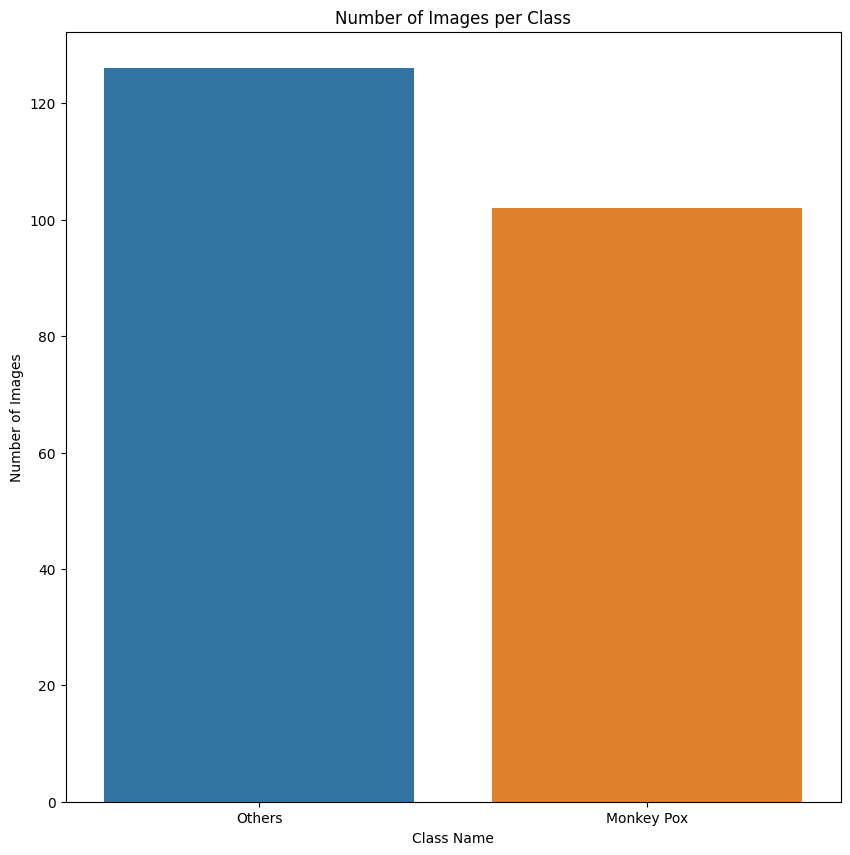

In [6]:
class_names = []
class_count = []
train_examples = 0

for f in os.listdir(tpath):
    files = gb.glob(pathname=str(tpath + "//" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)

plt.figure(figsize=(10,10))
sns.barplot(x=class_names, y=class_count)
plt.title('Number of Images per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.show()

# 6. Data Augmentation and Visualization
**Explanation:** This section defines an image data generator for augmentation (rescaling, flipping, etc.) and visualizes a batch of augmented images.

The ImageDataGenerator applies augmentations like rescaling, shearing, zooming, and flipping to artificially expand the dataset.

The code also loads and displays augmented images, allowing us to visualize how augmentation transforms the input data and helps with generalization during training.

In [8]:
# Defining Image Data Generator
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

Found 228 images belonging to 2 classes.


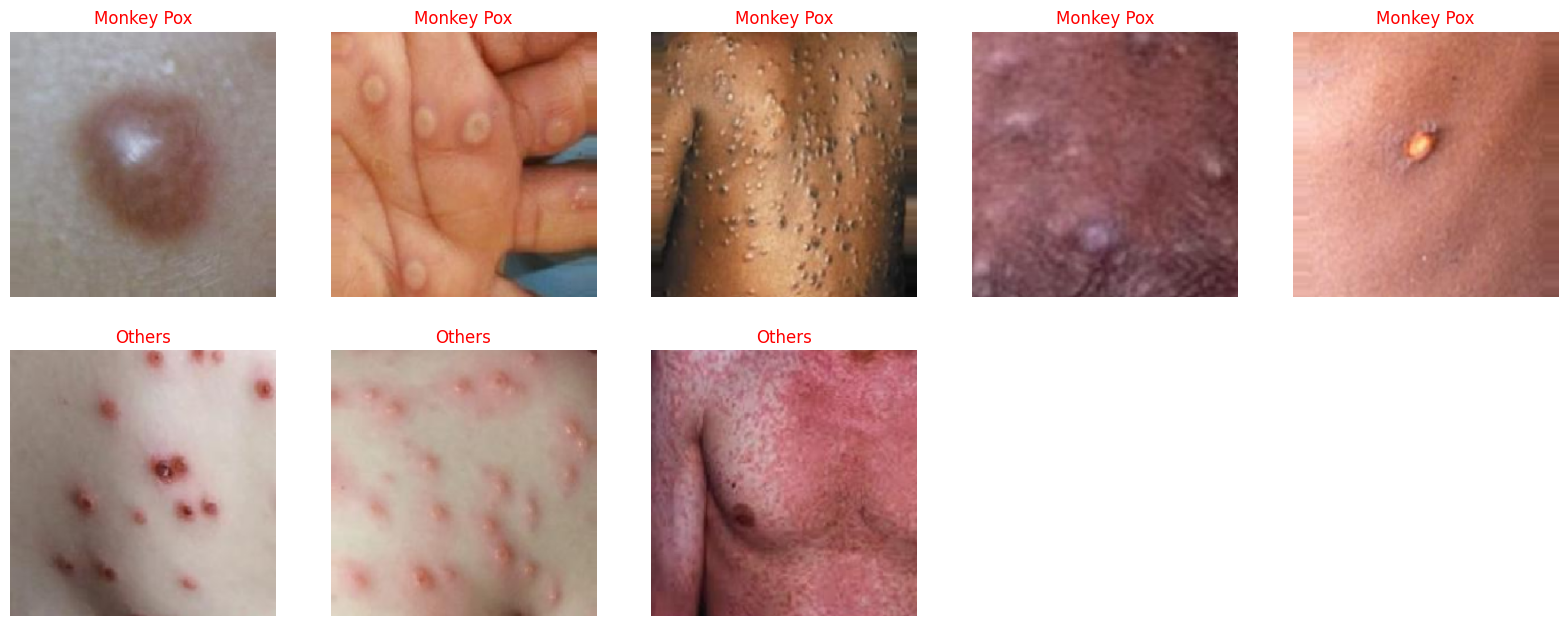

In [9]:
# Displaying Augmented Images
train_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(image_height, image_width),
    batch_size=batch_size,
)

g_dict = train_batch.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_batch)      

length = len(labels)        
sample = min(length, 30)    

plt.figure(figsize=(20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i]      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')
plt.show()

# 7. Building, Training, and Compiling the Model
**Explaination:** We use a pre-trained ResNet50 model as the backbone of our image classifier. This reduces training time and improves performance, as the model has been trained on a large dataset (ImageNet)

Transfer learning: ResNet50 is a powerful pre-trained model that already knows how to extract important features from images. By freezing its layers, we save computational resources and time by only training the new layers on our specific dataset.

Feature extraction and classification: The final fully connected layers allow the model to classify the extracted features from ResNet50 into the appropriate classes (Monkeypox vs. Others).

Efficient training: Using a simple optimizer (SGD) with a low learning rate helps fine-tune the new layers for better accuracy without overfitting.

In [8]:
from keras import layers
resnet_model = Sequential()
pretrained_model = keras.applications.ResNet50(
    include_top=False,
    input_shape=(image_height, image_width, 3),
    pooling='avg',
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(1024, activation='relu'))
resnet_model.add(layers.Dense(2, activation='softmax'))

resnet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 8. Model Training
**Explaination:** We train the model for 50 epochs, and monitor the accuracy and loss on both the training and validation datasets.

Model Training: The fit function performs the training process, where the model adjusts its weights based on the training data. This process continues for 50 epochs, allowing the model to improve its performance.

Validation: The validation data is used during training to evaluate the model's performance on unseen data, giving a measure of how well the model is likely to perform in real-world scenarios.

Epochs: Training over 50 epochs gives the model ample opportunity to learn and refine its weights while balancing the risk of overfitting.

In [9]:
epochs = 50
history = resnet_model.fit(
    training_data,
    validation_data=validation_data,
    epochs=epochs
)

Epoch 1/50


I0000 00:00:1726827802.808323     114 service.cc:145] XLA service 0x7cab080025d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726827802.808398     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 7/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4830 - loss: 0.7188

I0000 00:00:1726827806.657392     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 408ms/step - accuracy: 0.5522 - loss: 0.7080 - val_accuracy: 0.7111 - val_loss: 0.5550
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7333 - loss: 0.5505 - val_accuracy: 0.6444 - val_loss: 0.5663
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7271 - loss: 0.5325 - val_accuracy: 0.8000 - val_loss: 0.4736
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7866 - loss: 0.4741 - val_accuracy: 0.8444 - val_loss: 0.4439
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7785 - loss: 0.4562 - val_accuracy: 0.8000 - val_loss: 0.4422
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8121 - loss: 0.4234 - val_accuracy: 0.8444 - val_loss: 0.4095
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8469 - loss: 0.4096 - val_accuracy: 0.8667 - val_loss: 0.3964
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8580 - loss: 0.3931 - val_accuracy: 0.8667 - val_loss: 

# 9. Model Performance Visualization
**Explaination:** We plot the accuracy and loss for both the training and validation data over the course of training to see if the model is overfitting.

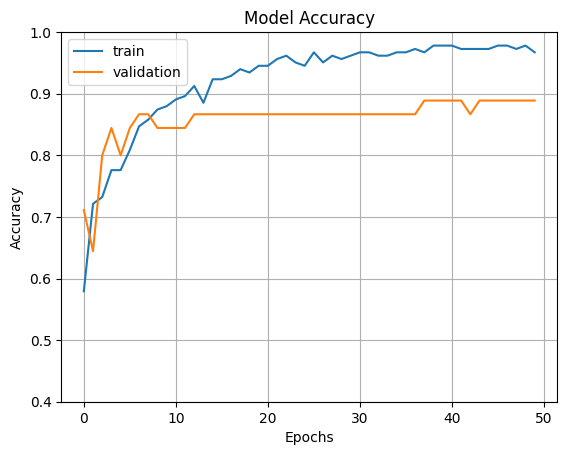

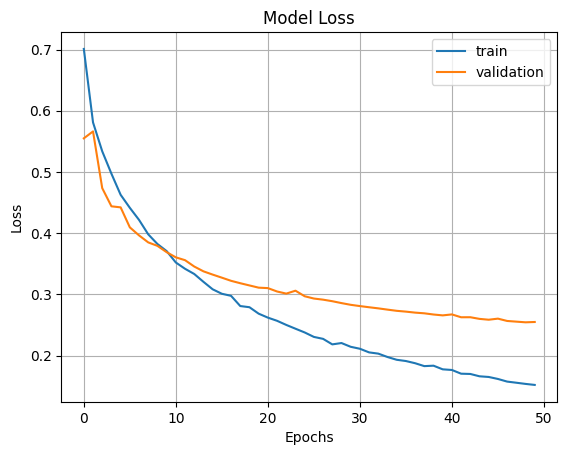

In [10]:
# Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.axis(ymin=0.4,ymax=1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

# 10. Model Prediction on New Images
**Explaination:** We use the trained model to make predictions on new, unseen images.

Prediction Function: The function is used to make predictions on new images, allowing us to assess the model's performance beyond the training and validation datasets. It processes the image to fit the model's input requirements and returns the predicted class.

Testing: The sample test cases on different images ensure that the model can correctly identify whether an image contains MonkeyPox or belongs to another class. This practical application of the model is crucial for deployment and real-world use cases.

In [11]:
# Prediction Function
def predict_image(image_path, model, class_names):
    img = load_img(image_path)
    img = img.resize((image_height, image_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    class_idx = np.argmax(y_pred, axis=1)[0]
    return class_names[class_idx]

In [14]:
# Define class names for prediction

class_names = ['MonkeyPox', 'Other']

# Test on a Monkeypox image
image_path = '/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images/Monkey Pox/M18_01.jpg'
print('Predicted Class name:', predict_image(image_path, resnet_model, class_names))

# Test on an Other image
image_path = '/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images/Others/NM07_01.jpg'
print('Predicted Class name:', predict_image(image_path, resnet_model, class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Class name: MonkeyPox
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class name: Other


# 11. Saving the Model
**Explaination:** Finally, we save the trained model for future use or deployment.

In [13]:
resnet_model.save('resnet_model.h5')

# 12. How to use the model
Step 1: Setup: Ensure you have Python and the required libraries (TensorFlow, NumPy, etc.) installed.

Step 2: Load the model

Step 3: Prediction on new images

In [ ]:
# Load the model
model = load_model('resnet_model.h5')

In [ ]:
# Define the class
class_names = ['MonkeyPox', 'Other']

In [ ]:
# Predicting Images: Use the predict_image function to classify images
print('Predicted Class name:', predict_image('image_path.jpg', model, class_names))

# 13. Conclusions
This notebook demonstrates how to load and preprocess image data, build and train a deep learning model using transfer learning, and evaluate its performance. Further improvements can be made by fine-tuning the model or using advanced architectures.